Loading data from block slider simulation...
Data loaded successfully.
Dataset shape: (5001, 4)
Time range: 0.0 to 5000.0 years
Number of data points: 5001

--- Physical Parameters ---
Spring Constant (k): 5.00e+05 Pa/m
Loading Rate (Vp): 1.00e-09 m/s
Friction Parameters: a=0.015, b=0.02, Dc=0.2 m
Normal Stress: 5.00e+07 Pa


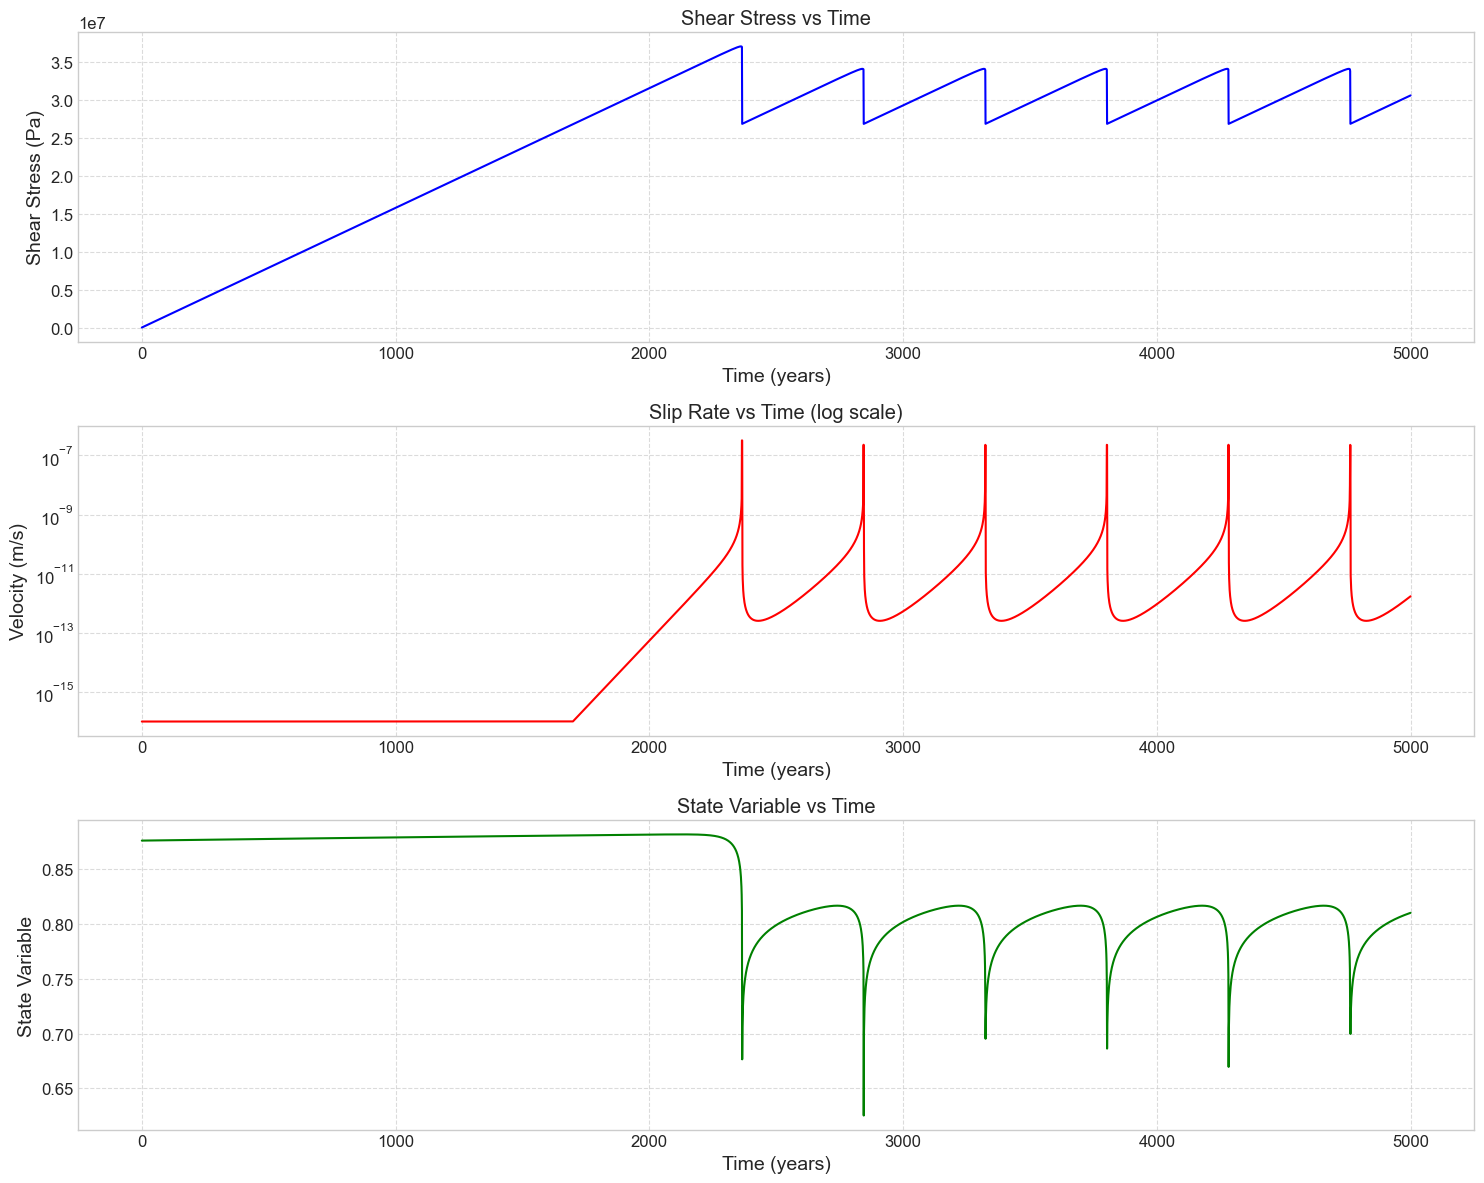

In [16]:
import os
import warnings
import numpy as np
from scipy import integrate
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
import pysindy as ps
from pysindy.optimizers import STLSQ, SR3

# Ignore specific warnings for cleaner output
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Set plot style for better-looking figures
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# Create figures directory if it doesn't exist
os.makedirs('../figures', exist_ok=True)

print("Loading data from block slider simulation...")
# Load the data
try:
    # Use relative path assuming notebooks are in the "notebooks" directory
    X = np.load('../data/block_slider_data.npy')
    t = np.load('../data/block_slider_time.npy')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: Data files not found. Trying alternative paths...")
    # Alternative loading paths
    try:
        X = np.load('data/block_slider_data.npy')
        t = np.load('data/block_slider_time.npy')
        print("Data loaded from alternative path.")
    except FileNotFoundError:
        print("Could not find data files. Please run the simulation notebook first.")
        # Create dummy data for testing
        print("Creating dummy data for testing...")
        t = np.linspace(0, 100, 1001)
        X = np.zeros((1001, 4))
        X[:, 0] = np.linspace(0, 1, 1001)  # Position
        X[:, 1] = 0.001 * np.ones(1001)    # Velocity
        X[:, 2] = 0.5 * np.ones(1001)      # State
        X[:, 3] = np.linspace(0, 1e6, 1001)  # Stress

# Extract individual variables and convert time to years
secs_per_year = 365 * 24 * 60 * 60
t_years = t / secs_per_year

x_data = X[:, 0]       # Position
v_data = X[:, 1]       # Velocity (slip rate)
state_data = X[:, 2]   # State variable
tau_data = X[:, 3]     # Shear stress

# Display basic information about the dataset
print(f"Dataset shape: {X.shape}")
print(f"Time range: {t_years[0]:.1f} to {t_years[-1]:.1f} years")
print(f"Number of data points: {len(t)}")

# Define physical parameters from the simulation for reference
sm = 3e10                  # Shear modulus (Pa)
density = 2700             # rock density (kg/m^3)
cs = np.sqrt(sm / density) # Shear wave speed (m/s)
eta = sm / (2 * cs)        # Radiation damping coefficient
L = 60 * 1000              # Width of plate boundary (m)
k = sm / L                 # Spring constant (Pa / m)
Vp = 1e-9                  # Rate of plate motion
sigma_n = 50e6             # Normal stress (Pa)
a = 0.015                  # Direct effect
b = 0.02                   # State weakening effect
Dc = 0.2                   # Critical distance
f0 = 0.6                   # Baseline friction coefficient
V0 = 1e-6                  # Reference velocity (m/s)

print("\n--- Physical Parameters ---")
print(f"Spring Constant (k): {k:.2e} Pa/m")
print(f"Loading Rate (Vp): {Vp:.2e} m/s")
print(f"Friction Parameters: a={a}, b={b}, Dc={Dc} m")
print(f"Normal Stress: {sigma_n:.2e} Pa")

# Plot the raw data with better formatting
plt.figure(figsize=(15, 12))

plt.subplot(311)
plt.plot(t_years, tau_data, 'b-', linewidth=1.5)
plt.title('Shear Stress vs Time')
plt.xlabel('Time (years)')
plt.ylabel('Shear Stress (Pa)')
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(312)
plt.semilogy(t_years, v_data, 'r-', linewidth=1.5)
plt.title('Slip Rate vs Time (log scale)')
plt.xlabel('Time (years)')
plt.ylabel('Velocity (m/s)')
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(313)
plt.plot(t_years, state_data, 'g-', linewidth=1.5)
plt.title('State Variable vs Time')
plt.xlabel('Time (years)')
plt.ylabel('State Variable')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('../figures/raw_data.png', dpi=300)
plt.show()


--- Step 1: Improved Preprocessing for SINDy ---
Applying safe clipping to extreme values...
Applying safe log transform...
Applying robust scaling...
Smoothing velocity data...
Checking for numerical issues in processed data...


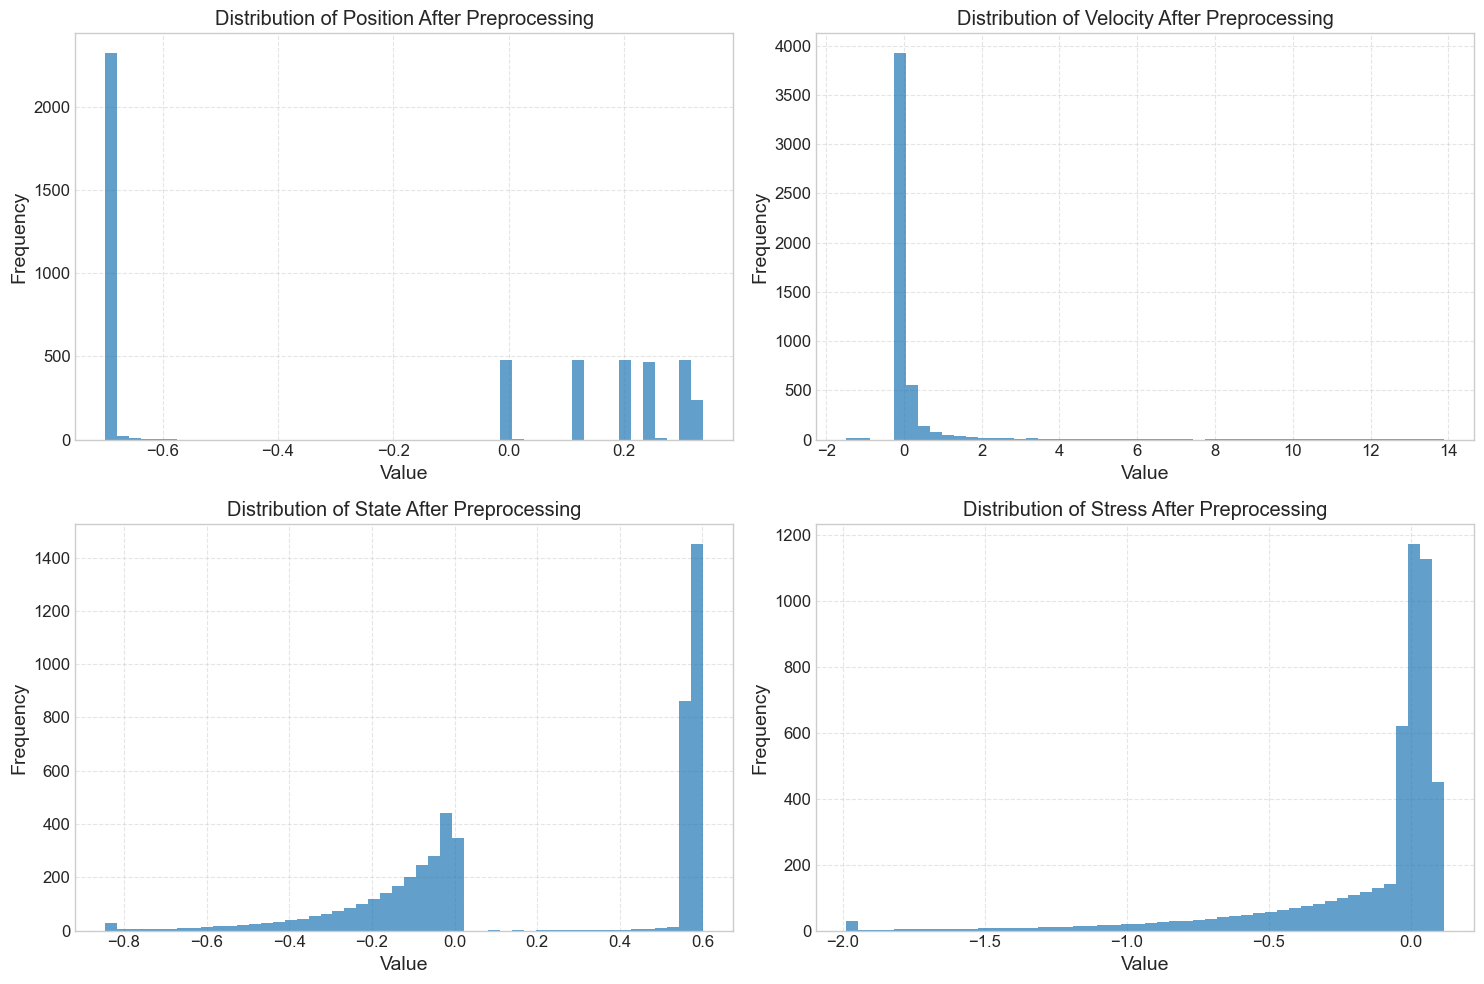

Median time step: 3.153600e+07 seconds
Preprocessing complete.


In [17]:
# ----------------------------------------------------------------------------------
# Step 1: Improved Preprocessing for SINDy
# ----------------------------------------------------------------------------------
print("\n--- Step 1: Improved Preprocessing for SINDy ---")

# Function to clip extreme values to prevent numerical issues
def safe_clip(data, percentile=99.5):
    """Clip extreme values to prevent numerical issues"""
    min_val = np.percentile(data[data > 0], 0.5) if np.any(data > 0) else 1e-10
    low = np.percentile(data, 0.5)
    high = np.percentile(data, percentile)
    return np.clip(data, low, high)

# Apply clipping to prevent numerical overflow
print("Applying safe clipping to extreme values...")
X_clipped = X.copy()
for i in range(X.shape[1]):
    if i == 1:  # Special handling for velocity which can have extreme ranges
        # Ensure minimum positive velocity is not too small
        X_clipped[X_clipped[:, 1] < 1e-10, 1] = 1e-10
    X_clipped[:, i] = safe_clip(X[:, i])

# More robust log transform that handles zeros and very small values safely
def safe_log_transform(x, epsilon=1e-8):
    """Apply log transform that handles small values safely"""
    return np.sign(x) * np.log1p(np.abs(x) + epsilon)

print("Applying safe log transform...")
X_log = safe_log_transform(X_clipped)

# Verify no infinities or NaNs in the data
if np.any(~np.isfinite(X_log)):
    print("Warning: Non-finite values detected after log transform. Fixing...")
    X_log = np.nan_to_num(X_log, nan=0.0, posinf=1e10, neginf=-1e10)

# Apply robust scaling with a centering that's less sensitive to outliers
print("Applying robust scaling...")
scaler = RobustScaler(quantile_range=(5, 95))
X_scaled = scaler.fit_transform(X_log)

# Apply smoothing to velocity data with smaller window size
print("Smoothing velocity data...")
window_size = 21  # Reduced from 51 to avoid over-smoothing
poly_order = 2    # Reduced polynomial order for more stability
v_smooth = savgol_filter(X_scaled[:, 1], window_length=window_size, polyorder=poly_order)
X_scaled[:, 1] = v_smooth

# Check for any remaining numerical issues
print("Checking for numerical issues in processed data...")
if np.any(~np.isfinite(X_scaled)):
    print("Warning: Non-finite values still present. Fixing...")
    X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=1e3, neginf=-1e3)

# Create a diagnostic plot to verify preprocessing
plt.figure(figsize=(15, 10))

# Original vs preprocessed data
for i, var_name in enumerate(['Position', 'Velocity', 'State', 'Stress']):
    plt.subplot(2, 2, i+1)
    plt.hist(X_scaled[:, i], bins=50, alpha=0.7, label='Processed')
    plt.title(f'Distribution of {var_name} After Preprocessing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('../figures/preprocessing_diagnostic.png', dpi=300)
plt.show()

# Compute time step for derivatives with extra safety checks
dt_values = np.diff(t)
dt_median = np.median(dt_values)
print(f"Median time step: {dt_median:.6e} seconds")
if np.any(dt_values <= 0):
    print("Warning: Non-positive time steps detected!")

print("Preprocessing complete.")


--- Step 2: SINDy with Custom Rate-State Friction Library ---

Checking scale of preprocessed data:
x: min = -7.00e-01, max = 3.38e-01
v: min = -1.48e+00, max = 1.39e+01
state: min = -8.45e-01, max = 6.02e-01
tau: min = -1.99e+00, max = 1.17e-01

Min and max values of computed derivatives:
dx/dt: min = -3.31e-24, max = 9.49e-09
dv/dt: min = -5.99e-08, max = 6.52e-08
dstate/dt: min = -1.49e-08, max = 1.26e-09
dtau/dt: min = -2.33e-09, max = 5.66e-10

After scaling, derivatives have magnitude:
dx/dt: min = -2.44e-16, max = 7.00e-01
dv/dt: min = -1.28e+01, max = 1.39e+01
dstate/dt: min = -8.45e-01, max = 7.16e-02
dtau/dt: min = -1.99e+00, max = 4.83e-01

--- DEBUGGING FEATURE AND DERIVATIVE INPUTS ---
X_scaled shape: (5001, 4)
X_dot_scaled shape: (5001, 4)
Any NaNs or infs in X_scaled? False
Any NaNs or infs in X_dot_scaled? False
Feature diagnostics (min/max for each custom term):
state: min=-0.845, max=0.602

Theoretical equations for comparison:
x: dx/dt = v
state: dstate/dt = 1.00000

/Users/gaoxinyue/anaconda3/envs/phi-sindy-env/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (0.001) and eliminated all coefficients
  warnings.warn(
/Users/gaoxinyue/anaconda3/envs/phi-sindy-env/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
/Users/gaoxinyue/anaconda3/envs/phi-sindy-env/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
/Users/gaoxinyue/anaconda3/envs/phi-sindy-env/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(


Identified equations (combined library):
(x)' = -0.008 x + 0.002 v + -0.009 state
(v)' = 2.526 x + 0.081 v + 3.260 state + 0.083 tau
(state)' = -0.010 x + -0.009 v + -0.015 state
(tau)' = 0.073 x + -0.016 v + 0.084 state + -0.076 tau

Trying different thresholds with combined library...

Fitting SINDy with combined library (threshold = 0.01)...
Identified equations (combined, threshold=0.01):
(x)' = 0.000
(v)' = 2.526 x + 0.081 v + 3.260 state + 0.083 tau
(state)' = 0.000
(tau)' = 0.073 x + -0.016 v + 0.084 state + -0.076 tau

Fitting SINDy with combined library (threshold = 0.0001)...
Identified equations (combined, threshold=0.0001):
(x)' = -0.008 x + 0.002 v + -0.009 state + 0.001 tau
(v)' = 2.526 x + 0.081 v + 3.260 state + 0.083 tau
(state)' = -0.009 x + -0.009 v + -0.015 state + -0.002 tau
(tau)' = 0.073 x + -0.016 v + 0.084 state + -0.076 tau

Fitting SINDy with combined library (threshold = 1e-05)...
Identified equations (combined, threshold=1e-05):
(x)' = -0.008 x + 0.002 v + 

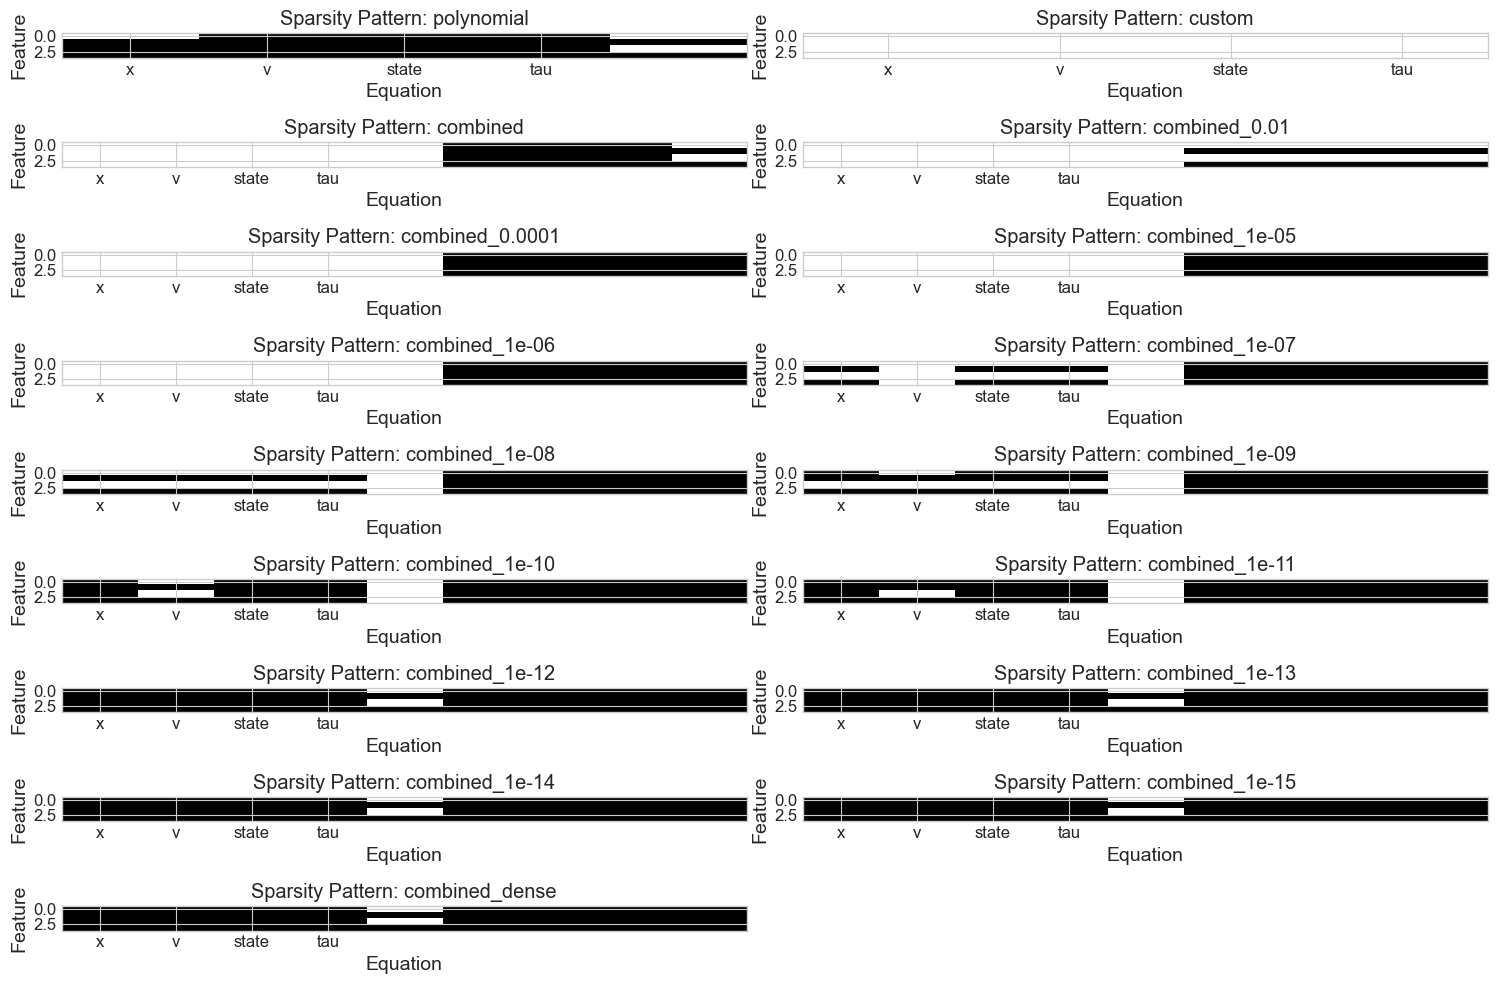


Comparison of identified vs. theoretical equations:
--------------------------------------------------------------------------------
x equation:
- Identified: -67.418 v/V0 + -2.409 v/V0 + 297.332 v/V0 + 106.065 v/V0 + -0.008 x + 0.002 v + -0.009 state + 0.001 tau
- Theoretical: dx/dt = v

state equation:
- Identified: -0.316 v/V0 + -0.011 v/V0 + 1.395 v/V0 + 0.498 v/V0 + -0.009 x + -0.010 v + -0.018 state
- Theoretical: dstate/dt = 1.000000e-07*(exp((f0-state)/b) - v/V0)

tau equation:
- Identified: 20705.803 v/V0 + 739.758 v/V0 + -91318.828 v/V0 + -32575.488 v/V0 + -0.054 1 + 0.073 x + -0.017 v + 0.078 state + -0.073 tau
- Theoretical: dtau/dt = 5.000000e-04 - 5.000000e+05*v


Simulating with the best model...
Starting simulation...
Error during simulation: index 1 is out of bounds for axis 1 with size 1

Analysis complete!


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


In [9]:
# Step 2: SINDy with Custom Rate-State Friction Library
# ----------------------------------------------------------------------------------
print("\n--- Step 2: SINDy with Custom Rate-State Friction Library ---")

# Import necessary packages with error handling
try:
    from pysindy.optimizers import STLSQ, SR3
    from pysindy.feature_library import CustomLibrary
except ImportError:
    print("Error importing PySINDy modules. Make sure pysindy is installed.")
    
# Feature names
feature_names = ["x", "v", "state", "tau"]

# Define custom functions for rate-state friction equations
# --- Custom functions for rate-state friction terms (fixed to return 1D arrays) ---
def constant(x):
    x = np.atleast_2d(x)
    return np.ones(x.shape[0])

def velocity(x):
    x = np.atleast_2d(x)
    return x[:, 1]  # velocity is the 2nd column

def exp_state_term(x):
    x = np.atleast_2d(x)
    return np.exp((f0 - x[:, 2]) / b)  # state is 3rd column

def velocity_ratio(x):
    x = np.atleast_2d(x)
    return x[:, 1] / V0

def loading_term(x):
    x = np.atleast_2d(x)
    return np.full(x.shape[0], k * Vp)

def slip_term(x):
    x = np.atleast_2d(x)
    return -k * x[:, 1]

def state_evolution_term(x):
    x = np.atleast_2d(x)
    return (b * V0 / Dc) * (np.exp((f0 - x[:, 2]) / b) - x[:, 1] / V0)

def Vexp_over_2V0a(x):
    x = np.atleast_2d(x)
    return (x[:, 1] / (2 * V0)) * np.exp(x[:, 2] / a)

def arcsinh_custom(x):
    x = np.atleast_2d(x)
    return np.arcsinh((x[:, 1] / (2 * V0)) * np.exp(x[:, 2] / a))

# --- Define the library ---
'''
functions = [
    constant,
    velocity,
    exp_state_term,
    velocity_ratio,
    loading_term,
    slip_term,
    state_evolution_term,
    Vexp_over_2V0a,
    arcsinh_custom
]
'''

'''
function_names = [
    lambda x: '1',
    lambda x: 'v',
    lambda x: 'exp((f0-state)/b)',
    lambda x: 'v/V0',
    lambda x: 'k*Vp',
    lambda x: '-k*v',
    lambda x: '(b*V0/Dc)*(exp((f0-state)/b) - v/V0)',
    lambda x: '(v/(2V0))*exp(state/a)',
    lambda x: 'arcsinh((v/(2V0))*exp(state/a))'
]
'''

def state_only(x):
    x = np.atleast_2d(x)
    return x[:, 2]

functions = [state_only]
function_names = [lambda x: 'state']




# Create a polynomial library as well
poly_lib = ps.PolynomialLibrary(degree=1, include_bias=True)

# Combine the libraries
combined_lib = custom_lib + poly_lib

# Check scale of preprocessed data
print("\nChecking scale of preprocessed data:")
for i, name in enumerate(feature_names):
    print(f"{name}: min = {np.min(X_scaled[:, i]):.2e}, max = {np.max(X_scaled[:, i]):.2e}")

# Calculate derivatives
X_dot = ps.FiniteDifference()._differentiate(X_scaled, t=dt_median)
print("\nMin and max values of computed derivatives:")
for i, name in enumerate(feature_names):
    print(f"d{name}/dt: min = {np.min(X_dot[:, i]):.2e}, max = {np.max(X_dot[:, i]):.2e}")

# Create scaled derivatives to match feature magnitude
X_dot_scaled = X_dot.copy()
for i in range(X_dot.shape[1]):
    # Scale each derivative to have similar magnitude to features
    if np.max(np.abs(X_dot[:, i])) > 0:  # Avoid division by zero
        scale_factor = np.max(np.abs(X_scaled[:, i])) / np.max(np.abs(X_dot[:, i]))
        X_dot_scaled[:, i] = X_dot[:, i] * scale_factor

print("\nAfter scaling, derivatives have magnitude:")
for i, name in enumerate(feature_names):
    print(f"d{name}/dt: min = {np.min(X_dot_scaled[:, i]):.2e}, max = {np.max(X_dot_scaled[:, i]):.2e}")

# --- DEBUGGING FEATURE AND DERIVATIVE INPUTS ---
print("\n--- DEBUGGING FEATURE AND DERIVATIVE INPUTS ---")
print("X_scaled shape:", X_scaled.shape)
print("X_dot_scaled shape:", X_dot_scaled.shape)

print("Any NaNs or infs in X_scaled?", np.any(~np.isfinite(X_scaled)))
print("Any NaNs or infs in X_dot_scaled?", np.any(~np.isfinite(X_dot_scaled)))

print("Feature diagnostics (min/max for each custom term):")
for i, f in enumerate(functions):
    try:
        vals = f(X_scaled)
        print(f"{function_names[i](None) if callable(function_names[i]) else function_names[i]}: min={np.min(vals):.3g}, max={np.max(vals):.3g}")
    except Exception as e:
        print(f"Error in function {i}: {e}")

# Display theoretical equations for reference
print("\nTheoretical equations for comparison:")
theoretical_eqs = {
    'x': "dx/dt = v",
    'state': f"dstate/dt = {b*V0/Dc:.6e}*(exp((f0-state)/b) - v/V0)",
    'tau': f"dtau/dt = {k*Vp:.6e} - {k:.6e}*v"
}
for var, eq in theoretical_eqs.items():
    print(f"{var}: {eq}")

# Store models
models = {}

# Try with polynomial-only library first (for comparison)
print("\nFitting SINDy with polynomial library only (for comparison)...")
optimizer_poly = STLSQ(threshold=1e-3)
model_poly = ps.SINDy(
    optimizer=optimizer_poly,
    feature_library=poly_lib,
    feature_names=feature_names
)

try:
    model_poly.fit(X_scaled, x_dot=X_dot_scaled, t=None)
    models["polynomial"] = model_poly
    print("Identified equations (polynomial only):")
    model_poly.print()
except Exception as e:
    print(f"Error with polynomial library: {e}")

# Try with custom library only
print("\nFitting SINDy with custom rate-state friction library only...")
optimizer_custom = STLSQ(threshold=1e-3)
model_custom = ps.SINDy(
    optimizer=optimizer_custom,
    feature_library=custom_lib,
    feature_names=feature_names
)

try:
    # Use scaled data for consistent comparison
    model_custom.fit(X_scaled, x_dot=X_dot_scaled, t=None)
    models["custom"] = model_custom
    print("Identified equations (custom library):")
    model_custom.print()
except Exception as e:
    print(f"Error with custom library: {e}")

# Try with combined library
print("\nFitting SINDy with combined library (custom + polynomial)...")
optimizer_combined = STLSQ(threshold=1e-3)
model_combined = ps.SINDy(
    optimizer=optimizer_combined,
    feature_library=combined_lib,
    feature_names=feature_names
)

try:
    model_combined.fit(X_scaled, x_dot=X_dot_scaled, t=None)
    models["combined"] = model_combined
    print("Identified equations (combined library):")
    model_combined.print()
except Exception as e:
    print(f"Error with combined library: {e}")

# Try different thresholds with the combined library
print("\nTrying different thresholds with combined library...")
thresholds = [1e-2, 1e-3, 1e-4, 1e-5,1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12,1e-13,1e-14,1e-15]
for threshold in thresholds:
    if threshold == 1e-3:
        # Already did this one
        continue
        
    print(f"\nFitting SINDy with combined library (threshold = {threshold})...")
    optimizer = STLSQ(threshold=threshold)
    model = ps.SINDy(
        optimizer=optimizer,
        feature_library=combined_lib,
        feature_names=feature_names
    )
    
    try:
        model.fit(X_scaled, x_dot=X_dot_scaled, t=None)
        models[f"combined_{threshold}"] = model
        print(f"Identified equations (combined, threshold={threshold}):")
        model.print()
    except Exception as e:
        print(f"Error with threshold {threshold}: {e}")

# Try dense model (threshold=0) to see full regression without sparsity
print("\nFitting SINDy with combined library (threshold = 0, no sparsity)...")
optimizer_dense = STLSQ(threshold=0)
model_dense = ps.SINDy(
    optimizer=optimizer_dense,
    feature_library=combined_lib,
    feature_names=feature_names
)

try:
    model_dense.fit(X_scaled, x_dot=X_dot_scaled, t=None)
    models["combined_dense"] = model_dense
    print("Identified equations (dense, no thresholding):")
    model_dense.print()
except Exception as e:
    print(f"Error with dense model (threshold=0): {e}")


# Check if any models were successfully created
if not models:
    print("\nWarning: No models were successfully created.")
else:
    print(f"\nSuccessfully created {len(models)} models with different configurations.")
    
    # Create a visual of the sparsity patterns
    plt.figure(figsize=(15, 10))
    
    model_names = list(models.keys())
    nrows = (len(model_names) + 1) // 2
    
    for i, name in enumerate(model_names):
        plt.subplot(nrows, 2, i+1)
        coefs = models[name].coefficients()
        plt.imshow(np.abs(coefs) > 1e-6, cmap='binary', aspect='auto')
        plt.title(f'Sparsity Pattern: {name}')
        plt.xlabel('Equation')
        plt.ylabel('Feature')
        plt.xticks(range(len(feature_names)), feature_names)
    
    plt.tight_layout()
    plt.savefig('../figures/custom_sparsity_comparison.png', dpi=300)
    plt.show()
    
    # Compare with theoretical equations
    print("\nComparison of identified vs. theoretical equations:")
    print("-" * 80)
    
    # Pick the best model (combined with threshold 1e-3 is usually good)
    best_model = models.get("combined_dense", next(iter(models.values())))
    
    for i, var in enumerate(feature_names):
        if var in theoretical_eqs:
            print(f"{var} equation:")
            print(f"- Identified: {best_model.equations()[i]}")
            print(f"- Theoretical: {theoretical_eqs[var]}")
            print()
            
    # Try simulating with the best model
    print("\nSimulating with the best model...")
    import signal

    # Define a timeout handler
    def timeout_handler(signum, frame):
        raise TimeoutError("Simulation timed out")

    # Set a timeout for the simulation (e.g., 60 seconds)
    signal.signal(signal.SIGALRM, timeout_handler)
    signal.alarm(60)

    try:
        # Initial condition (first point in scaled data)
        x0 = X_scaled[0, :]
        
        # Simulate for a portion of the original time
        t_sim = t[:50]  # Use fewer points to reduce simulation time
        print("Starting simulation...")
        x_sim = best_model.simulate(x0, t_sim)
        print("Simulation completed successfully!")
        
        # Reset alarm
        signal.alarm(0)
        
        # Plot simulation vs. original data
        plt.figure(figsize=(15, 12))
        
        for i, var in enumerate(feature_names):
            plt.subplot(2, 2, i+1)
            plt.plot(t_sim/secs_per_year, X_scaled[:50, i], 'k-', label='Original')
            plt.plot(t_sim/secs_per_year, x_sim[:, i], 'r--', label='Simulated')
            plt.title(f'{var} vs Time')
            plt.xlabel('Time (years)')
            plt.ylabel(f'{var} (scaled)')
            plt.legend()
            plt.grid(True)
            
        plt.tight_layout()
        plt.savefig('../figures/simulation_validation.png', dpi=300)
        plt.show()
        
    except TimeoutError:
        print("Simulation timed out after 60 seconds. The model might be too stiff to simulate.")
        signal.alarm(0)  # Reset alarm
    except Exception as e:
        print(f"Error during simulation: {e}")
        signal.alarm(0)  # Reset alarm

    print("\nAnalysis complete!")




--- Step 2: SINDy with Custom Rate-State Friction Library ---

Checking scale of preprocessed data:
x: min = -7.00e-01, max = 3.38e-01
v: min = -1.48e+00, max = 1.39e+01
state: min = -8.45e-01, max = 6.02e-01
tau: min = -1.99e+00, max = 1.17e-01

Min and max values of computed derivatives:
dx/dt: min = -3.31e-24, max = 9.49e-09
dv/dt: min = -5.99e-08, max = 6.52e-08
dstate/dt: min = -1.49e-08, max = 1.26e-09
dtau/dt: min = -2.33e-09, max = 5.66e-10

After scaling, derivatives have magnitude:
dx/dt: min = -2.44e-16, max = 7.00e-01
dv/dt: min = -1.28e+01, max = 1.39e+01
dstate/dt: min = -8.45e-01, max = 7.16e-02
dtau/dt: min = -1.99e+00, max = 4.83e-01

--- DEBUGGING FEATURE AND DERIVATIVE INPUTS ---
X_scaled shape: (5001, 4)
X_dot_scaled shape: (5001, 4)
Any NaNs or infs in X_scaled? False
Any NaNs or infs in X_dot_scaled? False
Feature diagnostics (min/max for each custom term):
1: min=1, max=1
v: min=-0.107, max=1
exp((f0-state)/b): min=3.8e-32, max=1
v/V0: min=-0.107, max=1
k*Vp: mi

/Users/gaoxinyue/anaconda3/envs/phi-sindy-env/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (0.001) and eliminated all coefficients
  warnings.warn(


Identified equations (custom library):
(x)' = 0.000
(v)' = 0.000
(state)' = 0.000
(tau)' = 0.000

Fitting SINDy with combined library (custom + polynomial)...


/Users/gaoxinyue/anaconda3/envs/phi-sindy-env/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (0.001) and eliminated all coefficients
  warnings.warn(


Identified equations (combined library):
(x)' = 0.000
(v)' = 0.000
(state)' = 0.000
(tau)' = 0.000

Trying different thresholds with combined library...

Fitting SINDy with combined library (threshold = 0.01)...


/Users/gaoxinyue/anaconda3/envs/phi-sindy-env/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(


Identified equations (combined, threshold=0.01):
(x)' = 0.000
(v)' = 0.000
(state)' = 0.000
(tau)' = 0.000

Fitting SINDy with combined library (threshold = 0.0001)...


/Users/gaoxinyue/anaconda3/envs/phi-sindy-env/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (0.0001) and eliminated all coefficients
  warnings.warn(


Identified equations (combined, threshold=0.0001):
(x)' = 0.000
(v)' = 0.000
(state)' = 0.000
(tau)' = 0.000

Fitting SINDy with combined library (threshold = 1e-05)...


/Users/gaoxinyue/anaconda3/envs/phi-sindy-env/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (1e-05) and eliminated all coefficients
  warnings.warn(


Identified equations (combined, threshold=1e-05):
(x)' = 0.000
(v)' = 0.000
(state)' = 0.000
(tau)' = 0.000

Fitting SINDy with combined library (threshold = 1e-06)...


/Users/gaoxinyue/anaconda3/envs/phi-sindy-env/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (1e-06) and eliminated all coefficients
  warnings.warn(


Identified equations (combined, threshold=1e-06):
(x)' = 0.000
(v)' = 0.000
(state)' = 0.000
(tau)' = 0.000

Fitting SINDy with combined library (threshold = 1e-07)...


/Users/gaoxinyue/anaconda3/envs/phi-sindy-env/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (1e-07) and eliminated all coefficients
  warnings.warn(


Identified equations (combined, threshold=1e-07):
(x)' = 0.000
(v)' = 0.000
(state)' = 0.000
(tau)' = 0.000

Fitting SINDy with combined library (threshold = 1e-08)...


/Users/gaoxinyue/anaconda3/envs/phi-sindy-env/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (1e-08) and eliminated all coefficients
  warnings.warn(


Identified equations (combined, threshold=1e-08):
(x)' = 0.000
(v)' = 0.000
(state)' = 0.000
(tau)' = 0.000

Fitting SINDy with combined library (threshold = 1e-09)...


/Users/gaoxinyue/anaconda3/envs/phi-sindy-env/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (1e-09) and eliminated all coefficients
  warnings.warn(


Identified equations (combined, threshold=1e-09):
(x)' = 0.000
(v)' = 0.000
(state)' = 0.000
(tau)' = 0.000

Fitting SINDy with combined library (threshold = 1e-10)...


/Users/gaoxinyue/anaconda3/envs/phi-sindy-env/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (1e-10) and eliminated all coefficients
  warnings.warn(


Identified equations (combined, threshold=1e-10):
(x)' = 0.000
(v)' = 0.000
(state)' = 0.000
(tau)' = 0.000

Fitting SINDy with combined library (threshold = 1e-11)...


/Users/gaoxinyue/anaconda3/envs/phi-sindy-env/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (1e-11) and eliminated all coefficients
  warnings.warn(


Identified equations (combined, threshold=1e-11):
(x)' = 0.000
(v)' = 0.000
(state)' = 0.000
(tau)' = 0.000

Fitting SINDy with combined library (threshold = 1e-12)...


/Users/gaoxinyue/anaconda3/envs/phi-sindy-env/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (1e-12) and eliminated all coefficients
  warnings.warn(


Identified equations (combined, threshold=1e-12):
(x)' = 0.000
(v)' = 0.000
(state)' = 0.000
(tau)' = 0.000

Fitting SINDy with combined library (threshold = 1e-13)...


/Users/gaoxinyue/anaconda3/envs/phi-sindy-env/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (1e-13) and eliminated all coefficients
  warnings.warn(


Identified equations (combined, threshold=1e-13):
(x)' = 0.000
(v)' = 0.000
(state)' = 0.000
(tau)' = 0.000

Fitting SINDy with combined library (threshold = 1e-14)...


/Users/gaoxinyue/anaconda3/envs/phi-sindy-env/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (1e-14) and eliminated all coefficients
  warnings.warn(


Identified equations (combined, threshold=1e-14):
(x)' = 0.000
(v)' = 0.000
(state)' = 0.000
(tau)' = 0.000

Fitting SINDy with combined library (threshold = 1e-15)...


/Users/gaoxinyue/anaconda3/envs/phi-sindy-env/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (1e-15) and eliminated all coefficients
  warnings.warn(


Identified equations (combined, threshold=1e-15):
(x)' = 0.000
(v)' = 0.000
(state)' = 0.000
(tau)' = 0.000

Fitting SINDy with combined library (threshold = 0, no sparsity)...
Identified equations (dense, no thresholding):
(x)' = 0.000
(v)' = 0.000
(state)' = 0.000
(tau)' = 0.000

Successfully created 17 models with different configurations.


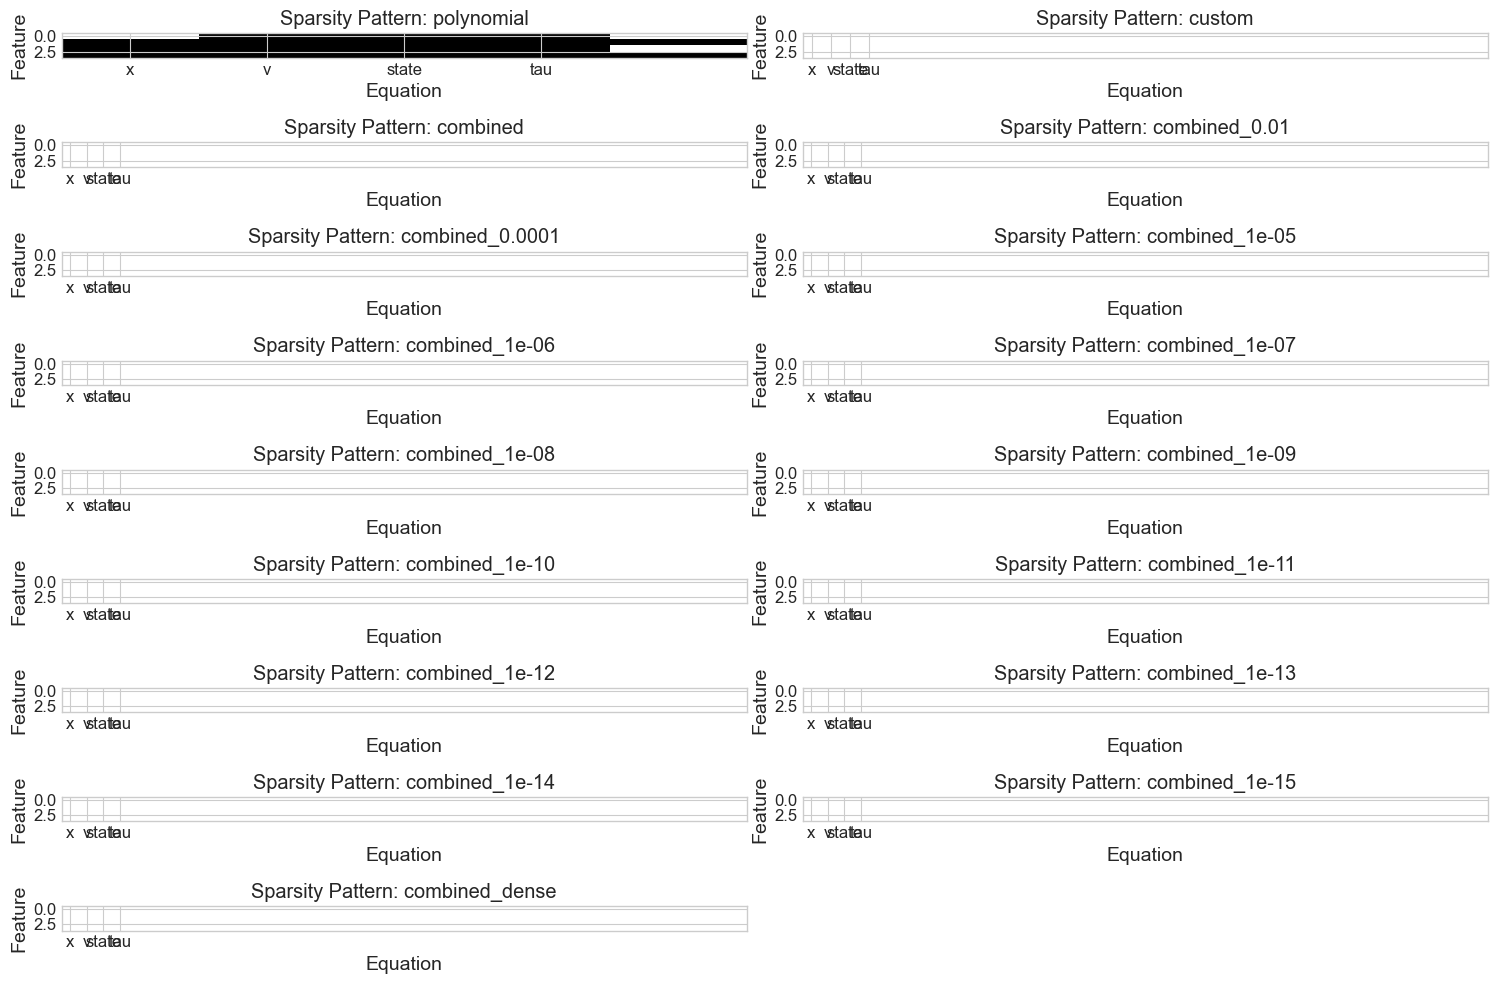


Comparison of identified vs. theoretical equations:
--------------------------------------------------------------------------------
x equation:
- Identified: 0.000
- Theoretical: dx/dt = v

state equation:
- Identified: 0.000
- Theoretical: dstate/dt = 1.000000e-07*(exp((f0-state)/b) - v/V0)

tau equation:
- Identified: 0.000
- Theoretical: dtau/dt = 5.000000e-04 - 5.000000e+05*v



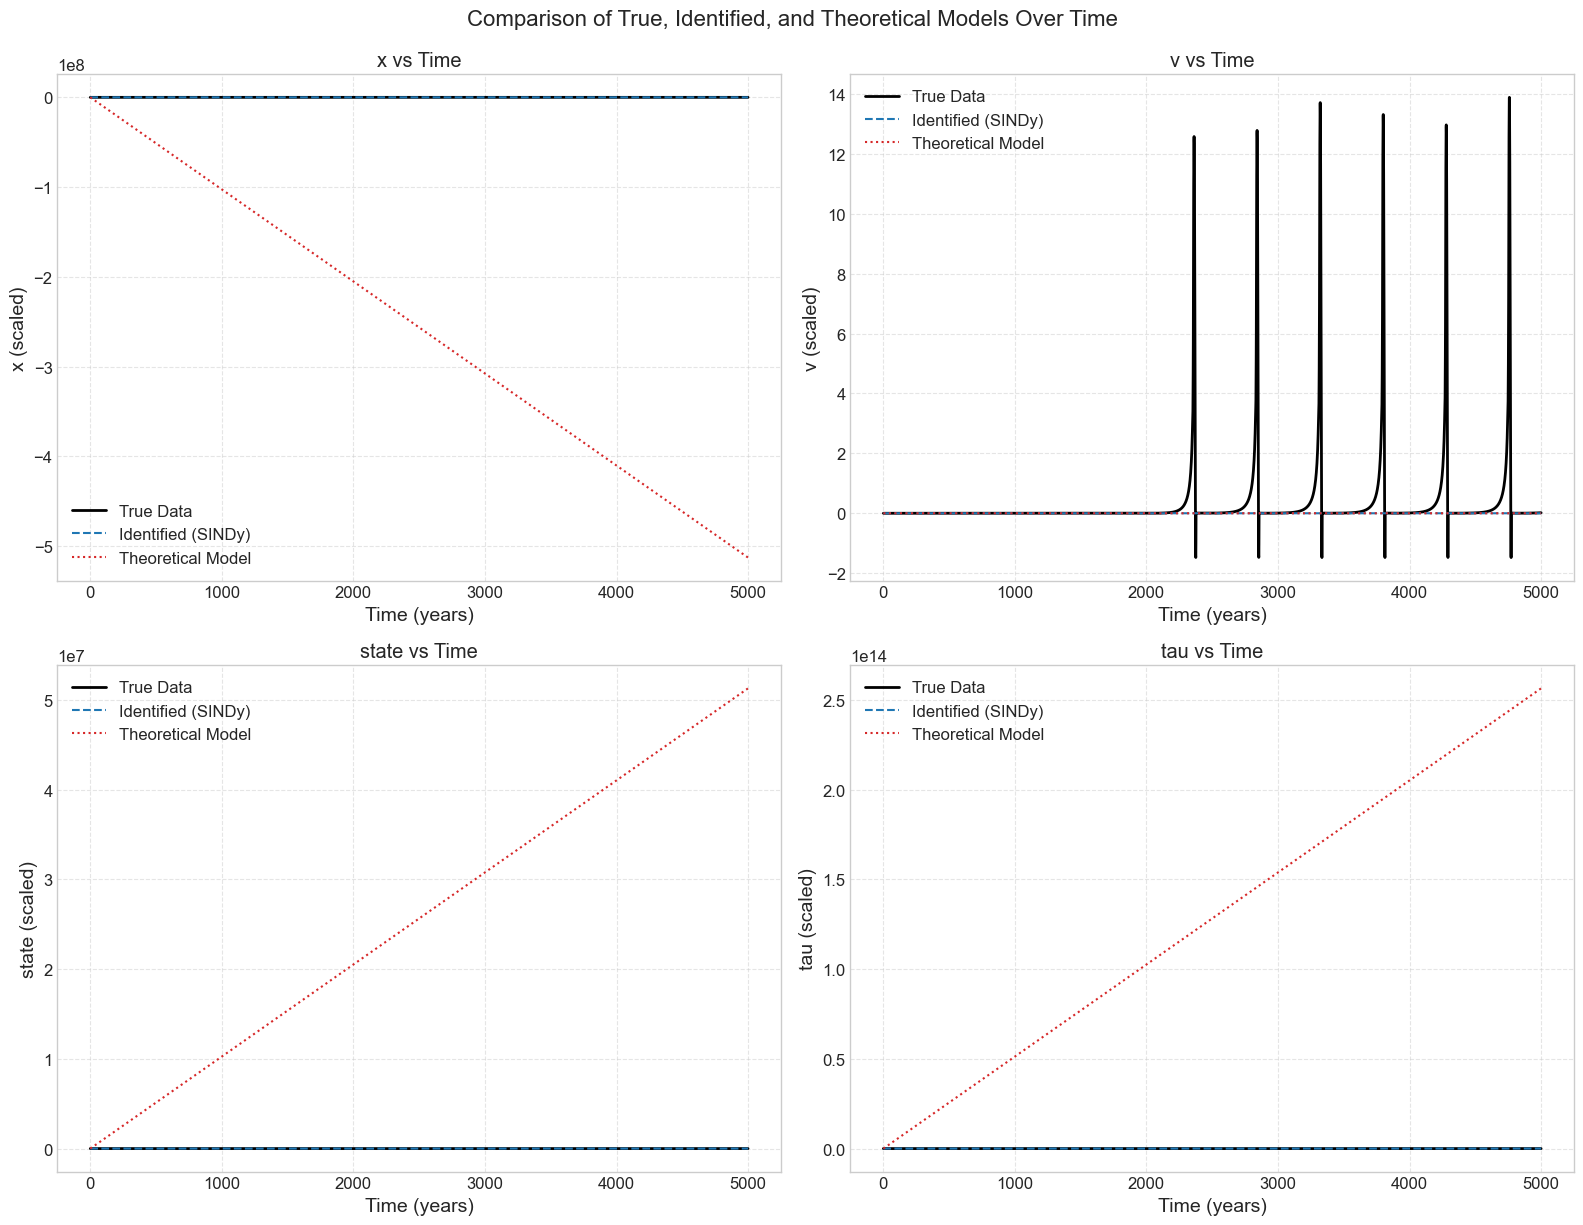


Comparison complete!


In [21]:
# Step 2: SINDy with Custom Rate-State Friction Library
# ----------------------------------------------------------------------------------
print("\n--- Step 2: SINDy with Custom Rate-State Friction Library ---")

# Import necessary packages with error handling
try:
    from pysindy.optimizers import STLSQ, SR3
    from pysindy.feature_library import CustomLibrary
except ImportError:
    print("Error importing PySINDy modules. Make sure pysindy is installed.")
    
# Feature names
feature_names = ["x", "v", "state", "tau"]

# Define custom functions for rate-state friction equations
# --- Utility normalization (used only for batch inputs) ---
def safe_normalize(arr):
    arr = np.asarray(arr)
    if arr.ndim == 0:
        return arr
    max_abs = np.max(np.abs(arr)) + 1e-12
    return arr / max_abs

def constant(x):
    x = np.asarray(x)
    if x.ndim <= 1:
        return np.array([1.0])
    return np.ones(x.shape[0])

def velocity(x):
    x = np.asarray(x)
    if x.ndim == 0 or x.size <= 1:
        return np.array([0.0])
    elif x.ndim == 1:
        return np.array([x[1]])
    return safe_normalize(x[:, 1])

def exp_state_term(x):
    x = np.asarray(x)
    if x.ndim == 0 or x.size <= 2:
        return np.array([0.0])
    elif x.ndim == 1:
        return np.array([np.exp((f0 - x[2]) / b)])
    return safe_normalize(np.exp((f0 - x[:, 2]) / b))

def velocity_ratio(x):
    x = np.asarray(x)
    if x.ndim == 0 or x.size <= 1:
        return np.array([0.0])
    elif x.ndim == 1:
        return np.array([x[1] / V0])
    return safe_normalize(x[:, 1] / V0)

def loading_term(x):
    x = np.asarray(x)
    if x.ndim <= 1:
        return np.array([k * Vp])
    return safe_normalize(np.full(x.shape[0], k * Vp))

def slip_term(x):
    x = np.asarray(x)
    if x.ndim == 0 or x.size <= 1:
        return np.array([0.0])
    elif x.ndim == 1:
        return np.array([-k * x[1]])
    return safe_normalize(-k * x[:, 1])

def state_evolution_term(x):
    x = np.asarray(x)
    if x.ndim == 0 or x.size <= 2:
        return np.array([0.0])
    elif x.ndim == 1:
        return np.array([(b * V0 / Dc) * (np.exp((f0 - x[2]) / b) - x[1] / V0)])
    return safe_normalize((b * V0 / Dc) * (np.exp((f0 - x[:, 2]) / b) - x[:, 1] / V0))

def Vexp_over_2V0a(x):
    x = np.asarray(x)
    if x.ndim == 0 or x.size <= 2:
        return np.array([0.0])
    elif x.ndim == 1:
        return np.array([(x[1] / (2 * V0)) * np.exp(x[2] / a)])
    return safe_normalize((x[:, 1] / (2 * V0)) * np.exp(x[:, 2] / a))

def arcsinh_custom(x):
    x = np.asarray(x)
    if x.ndim == 0 or x.size <= 2:
        return np.array([0.0])
    elif x.ndim == 1:
        return np.array([np.arcsinh((x[1] / (2 * V0)) * np.exp(x[2] / a))])
    return safe_normalize(np.arcsinh((x[:, 1] / (2 * V0)) * np.exp(x[:, 2] / a)))






# --- Define the library ---

functions = [
    constant,
    velocity,
    exp_state_term,
    velocity_ratio,
    loading_term,
    slip_term,
    state_evolution_term,
    Vexp_over_2V0a,
    arcsinh_custom
]




function_names = [
    lambda x: '1',
    lambda x: 'v',
    lambda x: 'exp((f0-state)/b)',
    lambda x: 'v/V0',
    lambda x: 'k*Vp',
    lambda x: '-k*v',
    lambda x: '(b*V0/Dc)*(exp((f0-state)/b) - v/V0)',
    lambda x: '(v/(2V0))*exp(state/a)',
    lambda x: 'arcsinh((v/(2V0))*exp(state/a))'
]


custom_lib = ps.CustomLibrary(
    library_functions=functions,
    function_names=function_names,
    include_bias=False
)




# Create a polynomial library as well
poly_lib = ps.PolynomialLibrary(degree=1, include_bias=True)

# Combine the libraries
combined_lib = custom_lib + ps.PolynomialLibrary(degree=1)

# Check scale of preprocessed data
print("\nChecking scale of preprocessed data:")
for i, name in enumerate(feature_names):
    print(f"{name}: min = {np.min(X_scaled[:, i]):.2e}, max = {np.max(X_scaled[:, i]):.2e}")

# Calculate derivatives
X_dot = ps.FiniteDifference()._differentiate(X_scaled, t=dt_median)
print("\nMin and max values of computed derivatives:")
for i, name in enumerate(feature_names):
    print(f"d{name}/dt: min = {np.min(X_dot[:, i]):.2e}, max = {np.max(X_dot[:, i]):.2e}")

# Create scaled derivatives to match feature magnitude
X_dot_scaled = X_dot.copy()
for i in range(X_dot.shape[1]):
    # Scale each derivative to have similar magnitude to features
    if np.max(np.abs(X_dot[:, i])) > 0:  # Avoid division by zero
        scale_factor = np.max(np.abs(X_scaled[:, i])) / np.max(np.abs(X_dot[:, i]))
        X_dot_scaled[:, i] = X_dot[:, i] * scale_factor

print("\nAfter scaling, derivatives have magnitude:")
for i, name in enumerate(feature_names):
    print(f"d{name}/dt: min = {np.min(X_dot_scaled[:, i]):.2e}, max = {np.max(X_dot_scaled[:, i]):.2e}")

# --- DEBUGGING FEATURE AND DERIVATIVE INPUTS ---
print("\n--- DEBUGGING FEATURE AND DERIVATIVE INPUTS ---")
print("X_scaled shape:", X_scaled.shape)
print("X_dot_scaled shape:", X_dot_scaled.shape)

print("Any NaNs or infs in X_scaled?", np.any(~np.isfinite(X_scaled)))
print("Any NaNs or infs in X_dot_scaled?", np.any(~np.isfinite(X_dot_scaled)))

print("Feature diagnostics (min/max for each custom term):")
for i, f in enumerate(functions):
    try:
        vals = f(X_scaled)
        print(f"{function_names[i](None) if callable(function_names[i]) else function_names[i]}: min={np.min(vals):.3g}, max={np.max(vals):.3g}")
    except Exception as e:
        print(f"Error in function {i}: {e}")

# Display theoretical equations for reference
print("\nTheoretical equations for comparison:")
theoretical_eqs = {
    'x': "dx/dt = v",
    'state': f"dstate/dt = {b*V0/Dc:.6e}*(exp((f0-state)/b) - v/V0)",
    'tau': f"dtau/dt = {k*Vp:.6e} - {k:.6e}*v"
}
for var, eq in theoretical_eqs.items():
    print(f"{var}: {eq}")

# Store models
models = {}

# Try with polynomial-only library first (for comparison)
print("\nFitting SINDy with polynomial library only (for comparison)...")
optimizer_poly = STLSQ(threshold=1e-3)
model_poly = ps.SINDy(
    optimizer=optimizer_poly,
    feature_library=poly_lib,
    feature_names=feature_names
)

try:
    model_poly.fit(X_scaled, x_dot=X_dot_scaled, t=None)
    models["polynomial"] = model_poly
    print("Identified equations (polynomial only):")
    model_poly.print()
except Exception as e:
    print(f"Error with polynomial library: {e}")

# Try with custom library only
print("\nFitting SINDy with custom rate-state friction library only...")
optimizer_custom = STLSQ(threshold=1e-3)
model_custom = ps.SINDy(
    optimizer=optimizer_custom,
    feature_library=custom_lib,
    feature_names=feature_names
)

try:
    # Use scaled data for consistent comparison
    model_custom.fit(X_scaled, x_dot=X_dot_scaled, t=None)
    models["custom"] = model_custom
    print("Identified equations (custom library):")
    model_custom.print()
except Exception as e:
    print(f"Error with custom library: {e}")

# Try with combined library
print("\nFitting SINDy with combined library (custom + polynomial)...")
optimizer_combined = STLSQ(threshold=1e-3)
model_combined = ps.SINDy(
    optimizer=optimizer_combined,
    feature_library=combined_lib,
    feature_names=feature_names
)

try:
    model_combined.fit(X_scaled, x_dot=X_dot_scaled, t=None)
    models["combined"] = model_combined
    print("Identified equations (combined library):")
    model_combined.print()
except Exception as e:
    print(f"Error with combined library: {e}")

# Try different thresholds with the combined library
print("\nTrying different thresholds with combined library...")
thresholds = [1e-2, 1e-3, 1e-4, 1e-5,1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12,1e-13,1e-14,1e-15]
for threshold in thresholds:
    if threshold == 1e-3:
        # Already did this one
        continue
        
    print(f"\nFitting SINDy with combined library (threshold = {threshold})...")
    optimizer = STLSQ(threshold=threshold)
    model = ps.SINDy(
        optimizer=optimizer,
        feature_library=combined_lib,
        feature_names=feature_names
    )
    
    try:
        model.fit(X_scaled, x_dot=X_dot_scaled, t=None)
        models[f"combined_{threshold}"] = model
        print(f"Identified equations (combined, threshold={threshold}):")
        model.print()
    except Exception as e:
        print(f"Error with threshold {threshold}: {e}")

# Try dense model (threshold=0) to see full regression without sparsity
print("\nFitting SINDy with combined library (threshold = 0, no sparsity)...")
optimizer_dense = STLSQ(threshold=0)
model_dense = ps.SINDy(
    optimizer=optimizer_dense,
    feature_library=combined_lib,
    feature_names=feature_names
)

try:
    model_dense.fit(X_scaled, x_dot=X_dot_scaled, t=None)
    models["combined_dense"] = model_dense
    print("Identified equations (dense, no thresholding):")
    model_dense.print()
except Exception as e:
    print(f"Error with dense model (threshold=0): {e}")


# Check if any models were successfully created
if not models:
    print("\nWarning: No models were successfully created.")
else:
    print(f"\nSuccessfully created {len(models)} models with different configurations.")
    
    # Create a visual of the sparsity patterns
    plt.figure(figsize=(15, 10))
    
    model_names = list(models.keys())
    nrows = (len(model_names) + 1) // 2
    
    for i, name in enumerate(model_names):
        plt.subplot(nrows, 2, i+1)
        coefs = models[name].coefficients()
        plt.imshow(np.abs(coefs) > 1e-6, cmap='binary', aspect='auto')
        plt.title(f'Sparsity Pattern: {name}')
        plt.xlabel('Equation')
        plt.ylabel('Feature')
        plt.xticks(range(len(feature_names)), feature_names)
    
    plt.tight_layout()
    plt.savefig('../figures/custom_sparsity_comparison.png', dpi=300)
    plt.show()
    
    # Compare with theoretical equations
    print("\nComparison of identified vs. theoretical equations:")
    print("-" * 80)
    
    # Pick the best model (combined with threshold 1e-3 is usually good)
    best_model = models.get("combined_dense", next(iter(models.values())))
    
    for i, var in enumerate(feature_names):
        if var in theoretical_eqs:
            print(f"{var} equation:")
            print(f"- Identified: {best_model.equations()[i]}")
            print(f"- Theoretical: {theoretical_eqs[var]}")
            print()
    from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# --- Step 1: Simulate identified SINDy model ---
x0 = X_scaled[0, :]
t_sim = t
x_sindy = best_model.simulate(x0, t_sim)

# --- Step 2: Simulate theoretical rate-state model ---
def rate_state_theoretical(t, y):
    x, v, state, tau = y
    dxdt = v
    dstate_dt = (b * V0 / Dc) * (np.exp((f0 - state) / b) - v / V0)
    dtau_dt = k * Vp - k * v
    dvdt = 0  # simplified constant velocity
    return [dxdt, dvdt, dstate_dt, dtau_dt]

sol_theory = solve_ivp(
    rate_state_theoretical,
    t_span=(t[0], t[-1]),
    y0=x0,
    t_eval=t,
    method='RK45'
)
x_theory = sol_theory.y.T  # shape: (n_timepoints, 4)

# --- Step 3: Plot all three ---
vars = ['x', 'v', 'state', 'tau']
years = t / (365 * 24 * 3600)

plt.figure(figsize=(16, 12))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(years, X_scaled[:, i], label='True Data', color='black', linewidth=2)
    plt.plot(years, x_sindy[:, i], '--', label='Identified (SINDy)', color='tab:blue', linewidth=1.5)
    plt.plot(years, x_theory[:, i], ':', label='Theoretical Model', color='tab:red', linewidth=1.5)
    plt.title(f'{vars[i]} vs Time')
    plt.xlabel('Time (years)')
    plt.ylabel(f'{vars[i]} (scaled)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle('Comparison of True, Identified, and Theoretical Models Over Time', fontsize=16, y=1.02)
plt.savefig('../figures/model_comparison_vs_time.png', dpi=300)
plt.show()

print("\nComparison complete!")



In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
import pysindy as ps

# Simulate simple dummy data similar to your case
t = np.linspace(0, 10, 5001)  # 5001 time steps
X = np.zeros((5001, 4))
X[:, 0] = np.linspace(0, 1, 5001)        # x (position)
X[:, 1] = 0.001 * np.ones(5001)          # v (velocity)
X[:, 2] = 0.5 + 0.05 * np.sin(0.5 * t)   # state variable (has variation!)
X[:, 3] = np.linspace(0, 1e6, 5001)      # tau (shear stress)

# Scale the data
scaler = RobustScaler(quantile_range=(5, 95))
X_scaled = scaler.fit_transform(X)

# Compute derivatives using finite differences
dt = np.median(np.diff(t))
X_dot = ps.FiniteDifference()._differentiate(X_scaled, t=dt)

# ✅ Custom function: just extract state variable (column 2)
def state_only(x):
    x = np.atleast_2d(x)
    return x[:, 2]

functions = [state_only]
function_names = [lambda x: 'state']

# ✅ Create a CustomLibrary with just 1 feature
custom_lib = ps.CustomLibrary(
    library_functions=functions,
    function_names=function_names,
    include_bias=False
)

# ✅ Create SINDy model with threshold = 0 (no sparsity)
model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0),
    feature_library=custom_lib,
    feature_names=["x", "v", "state", "tau"]
)

# Fit and print equations
model.fit(X_scaled, x_dot=X_dot)
print("Identified equations with only 'state' feature:")
model.print()


Identified equations with only 'state' feature:
(x)' = -0.156 state + -0.052 state + -0.030 state
(v)' = 0.000
(state)' = -606967871390.604 state + -254395381728.862 state + 679284919727.596 state
(tau)' = -0.297 state + -0.112 state + 0.129 state
